In [13]:
# Google Colab library
try:
    from google.colab import drive
    in_colab = True
    import torch_xla.core.xla_model as xm
    
    print("In Google Colab")
except:
    in_colab = False
    print("Not in Google Colab")
    pass

Not in Google Colab


In [14]:
# Python library
import os
import zipfile
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing

import yaml
import albumentations as A

from concurrent.futures import ThreadPoolExecutor, as_completed

# Sklearn library
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Pytorch library
import torch
from torch import optim, nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# CV2 library
import cv2

In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("Cuda version: ", torch.version.cuda)

Device:  cuda
Cuda version:  12.4


In [16]:
# Load configuration
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

# Project information
print('Project name: ', config['project']['name'])
print('Project version: ', config['project']['description'])
print('Project author: ', config['project']['author'])
print('Project version: ', config['project']['version'])

# Data location
print('Data path: ', config['data'])
data_path = config['data']['raw_path']
csv_path = config['data']['raw_csv_path']
images_path = config['data']['raw_images_path']

# Training configuration
if in_colab:
    n_workers = multiprocessing.cpu_count()
    batch_size = 128
else:
    n_workers = config['hyperparameters']['n_workers']
    batch_size = config['hyperparameters']['batch_size']
print('N workers: ', n_workers)
print('Batch size: ', batch_size)

# Preprocessing configuration
print('Preprocessing configuration')
augmentation_ratio = config['preprocessing']['augmentation']['ratio']
resize_shape = tuple(config['preprocessing']['resize'])
print('Augmentation ratios: ', augmentation_ratio)
print('Resize shape: ', resize_shape)

# Create a dictionary for images location
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Project name:  Cancer Detection
Project version:  DPL302m Project - Fall 2024 of Group 1
Project author:  Group 1
Project version:  1.0.0
Data path:  {'data_path': 'data/', 'raw_path': 'data/raw/', 'raw_csv_path': 'data/raw/HAM10000_metadata.csv', 'raw_images_path': 'data/raw/images/', 'processed_path': 'data/processed/', 'processed_images_path': 'data/processed/images/'}
N workers:  16
Batch size:  32
Preprocessing configuration
Augmentation ratios:  1
Resize shape:  (224, 224)


In [17]:
# Load the data
if os.path.exists(f'data/processed/HAM10000_{resize_shape[0]}x{resize_shape[1]}_train.pt'):
    print('Data is already processed')
else:
    print('Data is not processed yet')
    from scripts.preprocessing import *
    preprocessor = DataProcessor(config_path='config.yaml')
    preprocessor.run(aug=True, rate = 1)
    print('Data is processed')

Data is already processed


In [18]:
# Step 2: Model building
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    # Variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "Densenet121":
        weights = 'DEFAULT' if use_pretrained else None
        model_ft = models.densenet121(weights=weights)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = config['preprocessing']['resize'][0]
    
    elif model_name == "Resnet18":
        # Add initialization for Resnet18 if needed
        pass

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Step 3: Model training
model_name = config['hyperparameters']['model_name']
num_classes = config['hyperparameters']['num_classes']
feature_extract = config['hyperparameters']['feature_extract']
use_pretrained = config['hyperparameters']['use_pretrained']


# Initialize the model for this run and move it to the device
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained)
model = model_ft.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
class HAM10000(Dataset):
    def __init__(self, data_file):
        # Load the merged data
        data = torch.load(data_file)
        self.images = data['images']
        self.labels = data['data']
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        X = self.images[index]
        y = torch.tensor(self.labels[index])
        return X, y

# Define location of prepared data
size = config['preprocessing']['resize'][0]

encoder_file = f'encoder/{size}x{size}.pt'
train_data_file = f'data/processed/HAM10000_{size}x{size}_train.pt'
test_data_file = f'data/processed/HAM10000_{size}x{size}_test.pt'

# Load the encoder
encoder = torch.load(encoder_file)

# Load the training data
train_data = HAM10000(train_data_file)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

# Load the test data
test_data = HAM10000(test_data_file)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

C:\Users\fxlqt\AppData\Local\Temp\ipykernel_5568\798468676.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load(encoder_file)
C:\Users\fxlqt\AppData\Loc

In [20]:
# We use Adam optimizer, use cross entropy loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [21]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [22]:
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % (len(train_loader) // 10) == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [23]:
def validate(test_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [24]:
total_loss_train, total_acc_train = [],[]
epoch_num = 50
# epoch_num = config['hyperparameters']['epochs']
print('Start training...  on image size: ', config['preprocessing']['resize'], ' with epoch: ', epoch_num)
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    print('Training on epoch {}'.format(epoch))
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(test_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

Start training...  on image size:  [224, 224]  with epoch:  50
Training on epoch 1
[epoch 1], [iter 112 / 1121], [train loss 1.93401], [train acc 0.21680]
[epoch 1], [iter 224 / 1121], [train loss 1.90373], [train acc 0.23061]
[epoch 1], [iter 336 / 1121], [train loss 1.88622], [train acc 0.24284]
[epoch 1], [iter 448 / 1121], [train loss 1.87096], [train acc 0.25119]
[epoch 1], [iter 560 / 1121], [train loss 1.85811], [train acc 0.26032]
[epoch 1], [iter 672 / 1121], [train loss 1.84689], [train acc 0.26828]
[epoch 1], [iter 784 / 1121], [train loss 1.83254], [train acc 0.27691]
[epoch 1], [iter 896 / 1121], [train loss 1.82051], [train acc 0.28418]
[epoch 1], [iter 1008 / 1121], [train loss 1.80960], [train acc 0.29164]
[epoch 1], [iter 1120 / 1121], [train loss 1.80229], [train acc 0.29704]
------------------------------------------------------------
[epoch 1], [val loss 1.81685], [val acc 0.37198]
------------------------------------------------------------
************************

In [28]:
# Save the model
# Check the name of last model in the folder
model_path = 'saved_models/'
model_name = f'{size}_{size}_{epoch_num}epoch_{best_val_acc:.2f}acc.pth'
model_name = os.path.join(model_path, model_name)
torch.save(model.state_dict(), model_name)
print('Model saved: ', model_name)

Model saved:  saved_models/224_224_50epoch_0.51acc.pth


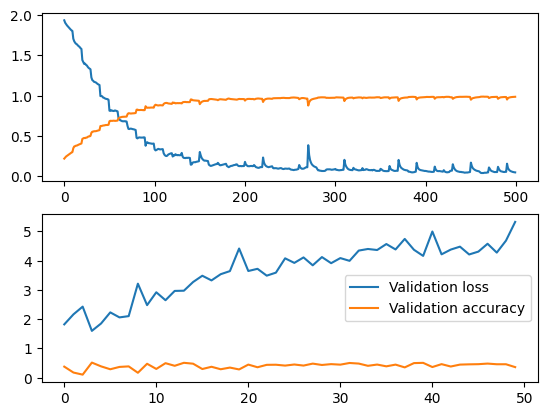

In [29]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'Training loss')
fig1.plot(total_acc_train, label = 'Training accuracy')
fig2.plot(total_loss_val, label = 'Validation loss')
fig2.plot(total_acc_val, label = 'Validation accuracy')
plt.legend()
plt.show()

In [27]:
# Classification report